In [11]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import time
import pickle
import numpy as np

In [12]:
data_file = '../../data/Mumbai_House_Price.csv'
model_file = '../../models/RandomForest_1'

In [13]:
data = pd.read_csv(data_file)
# Process type  ( Apartment: 0, Independent House: 1, Studio Apartment: 2, villa: 3 )
# Process status ( Ready to move: 0, under Construction: 1 )
for column in data:
    if column in ["bhk","status","type","age"]:
        print("Column Name: ", column)
        print(data[column].unique())
        print(data[column].value_counts())

Column Name:  bhk
[ 3  2  5  1  4  6  9  8 10  7]
bhk
2     31429
1     24613
3     15273
4      3934
5       606
6       148
7        16
8         8
10        6
9         5
Name: count, dtype: int64
Column Name:  type
['Apartment' 'Villa' 'Studio Apartment' 'Independent House' 'Penthouse']
type
Apartment            74854
Studio Apartment       882
Villa                  226
Independent House       73
Penthouse                3
Name: count, dtype: int64
Column Name:  status
['Ready to move' 'Under Construction']
status
Ready to move         44982
Under Construction    31056
Name: count, dtype: int64
Column Name:  age
['New' 'Resale' 'Unknown']
age
New        38072
Resale     23357
Unknown    14609
Name: count, dtype: int64


In [14]:
def preprocessing(data: pd.DataFrame) -> pd.DataFrame:
    for index in data.index:
        price = data.loc[index, 'price']
        price_unit = data.loc[index, 'price_unit']
        # Process price
        if price_unit == 'Cr':
            data.loc[index, 'price_in_USD'] = (price * 10000000 * 0.012)
        elif price_unit == 'L':
            data.loc[index, 'price_in_USD'] = (price * 100000 * 0.012)
    data.drop(['price_unit',"price"], axis = 1, inplace = True)
    data = data.dropna()
    return data


In [15]:
processed_data = preprocessing(data)
for column in processed_data:
    print("Column Name: ", column)
    print(processed_data[column].unique())
    print(processed_data[column].value_counts())

Column Name:  bhk
[ 3  2  5  1  4  6  9  8 10  7]
bhk
2     31429
1     24613
3     15273
4      3934
5       606
6       148
7        16
8         8
10        6
9         5
Name: count, dtype: int64
Column Name:  type
['Apartment' 'Villa' 'Studio Apartment' 'Independent House' 'Penthouse']
type
Apartment            74854
Studio Apartment       882
Villa                  226
Independent House       73
Penthouse                3
Name: count, dtype: int64
Column Name:  locality
['Lak And Hanware The Residency Tower' 'Radheya Sai Enclave Building No 2'
 'Romell Serene' ... 'Ahuja Prasadam Phase III' 'HBS Marineview'
 'Hubtown Serene']
locality
Hiranandani Meadows                    861
Sheth Avalon                           516
T Bhimjyani The Verraton               499
ACME Ozone Phase 2                     467
Runwal Gardens                         389
                                      ... 
HP Anton CHSL Rishab Anton               1
Reputed Builder Shankar Heritage         1
Reputed

In [16]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
X = processed_data.drop(labels="price_in_USD",axis=1)
for column in X:
    if column in ["locality","region", "status", "age","type"]:
        X[column] = le.fit_transform(X[column])
Y = processed_data["price_in_USD"]
print(X.shape)
print(Y.shape)

(76038, 7)
(76038,)


In [17]:
from sklearn.model_selection import train_test_split
X_hold, X_test, Y_hold, Y_test = train_test_split(X,Y,test_size=0.25,random_state=0)
X_train, X_val, Y_train,Y_val = train_test_split(X_hold,Y_hold,test_size=0.25,random_state=0)

In [18]:
# from sklearn.model_selection import validation_curve
# 
# parameter_range = np.arange(1, 25, 1)
# 
# # Calculate accuracy on training and test set using the
# # gamma parameter with 4-fold cross validation
# train_score, val_score = validation_curve(RandomForestRegressor(n_estimators=10, random_state=42), X_hold, Y_hold,
#                                           param_name="max_depth",
#                                           param_range=parameter_range,
#                                           cv=4, scoring="r2")
# 
# mean_train_score = np.mean(train_score, axis=1)
# std_train_score = np.std(train_score, axis=1)
# 
# mean_val_score = np.mean(val_score, axis=1)
# std_val_score = np.std(val_score, axis=1)
# 
# plt.plot(parameter_range, mean_train_score,
#          label="Training Score", color='b')
# plt.plot(parameter_range, mean_val_score,
#          label="Cross Validation Score", color='g')
# # Creating the plot
# plt.title("Validation Curve with Random Forest Regressor")
# plt.xlabel("Max depth")
# plt.ylabel("R2 Score")
# plt.tight_layout()
# plt.legend(loc='best')
# plt.show()

In [19]:
# from sklearn.model_selection import validation_curve
# 
# parameter_range = ["squared_error","absolute_error","friedman_mse", "poisson"]
# 
# # Calculate accuracy on training and test set using the
# # gamma parameter with 4-fold cross validation
# train_score, val_score = validation_curve(RandomForestRegressor(n_estimators=10, max_depth=20, random_state=42), X_hold, Y_hold,
#                                           param_name="criterion",
#                                           param_range=parameter_range,
#                                           cv=4, scoring="r2")
# mean_train_score = np.mean(train_score, axis=1)
# std_train_score = np.std(train_score, axis=1)
# 
# mean_val_score = np.mean(val_score, axis=1)
# std_val_score = np.std(val_score, axis=1)
# 
# plt.plot(parameter_range, mean_train_score,
#          label="Training Score", color='b')
# plt.plot(parameter_range, mean_val_score,
#          label="Cross Validation Score", color='g')
# # Creating the plot
# plt.title("Validation Curve with Random Forest Regressor")
# plt.xlabel("Criterion")
# plt.ylabel("R2 Score")
# plt.tight_layout()
# plt.legend(loc='best')
# plt.show()

In [20]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [100,200],'max_depth': np.arange(15, 30, 1),'max_features': ['auto', 'sqrt','log2']}
def hypersearch(model, model_name, param_grid, X_train, Y_train, scoring='r2'):
    # Hyperparameter tuning
    rs = GridSearchCV(model, param_grid, cv=4, scoring=scoring, return_train_score=True)
    rs.fit(X_train, Y_train)
    best_model = rs.best_estimator_

    #add the report about best hyperparameter of the model to dataframe
    result = pd.DataFrame(rs.cv_results_)
    result.sort_values('rank_test_score', inplace=True)
    result = result[['params', 'mean_fit_time', 'mean_score_time', 'mean_test_score', 'mean_train_score']]
    display(result)
    
    pickle.dump(best_model, open(model_name, 'wb'))
    return best_model

model = hypersearch(RandomForestRegressor(random_state=42), model_file, param_grid, X, Y)

D:\Anaconda\Lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


,params,mean_fit_time,mean_score_time,mean_test_score,mean_train_score
73,"{'criterion': 'squared_error', 'max_depth': 27...",47.992285,0.973404,0.829248,0.981202
49,"{'criterion': 'squared_error', 'max_depth': 23...",43.716674,0.809380,0.828808,0.980197
79,"{'criterion': 'squared_error', 'max_depth': 28...",47.811108,0.992694,0.828584,0.981273
61,"{'criterion': 'squared_error', 'max_depth': 25...",45.173832,0.902795,0.828509,0.980847
55,"{'criterion': 'squared_error', 'max_depth': 24...",45.146755,0.880646,0.828222,0.980532
...,...,...,...,...,...
8,"{'criterion': 'squared_error', 'max_depth': 16...",7.118382,0.260580,0.765543,0.941081
5,"{'criterion': 'squared_error', 'max_depth': 15...",12.713591,0.434082,0.760058,0.929660
3,"{'criterion': 'squared_error', 'max_depth': 15...",12.034420,0.477269,0.760058,0.929660
4,"{'criterion': 'squared_error', 'max_depth': 15...",6.507814,0.219064,0.758819,0.928550


In [23]:
# from sklearn.model_selection import learning_curve
# 
# # Calculate accuracy on training and test set using the
# # gamma parameter with 4-fold cross validation
# train_sizes, train_score, val_score = learning_curve(RandomForestRegressor(n_estimators=10, random_state=42), X_hold, Y_hold,
#                                           cv=4, train_sizes=np.linspace(0.1, 1.0, 10),scoring="r2")
# 
# train_score_mean = np.mean(train_score, axis=1)
# train_score_std = np.std(train_score, axis=1)
# 
# val_score_mean = np.mean(val_score, axis=1)
# val_score_std = np.std(val_score, axis=1)
# 
# plt.plot(train_sizes, train_score_mean,
#          label="Training Score", color='b')
# plt.plot(train_sizes, val_score_mean,
#          label="Cross Validation Score", color='g')
# # Creating the plot
# plt.title("Learning Curve with Random Forest Regressor")
# plt.xlabel("Training examples")
# plt.ylabel("R2 Score")
# plt.tight_layout()
# plt.legend(loc='best')
# plt.show()

In [24]:
# start = time.time()
# # Create the model
# model = RandomForestRegressor(n_estimators=10, random_state=42)
# print("Start training...")
# model.fit(X_train, Y_train)
# end = time.time()
# print("Time execution : ", end - start)
# pickle.dump(model, open(model_file, 'wb'))

In [25]:
loaded_model = pickle.load(open(model_file, 'rb'))

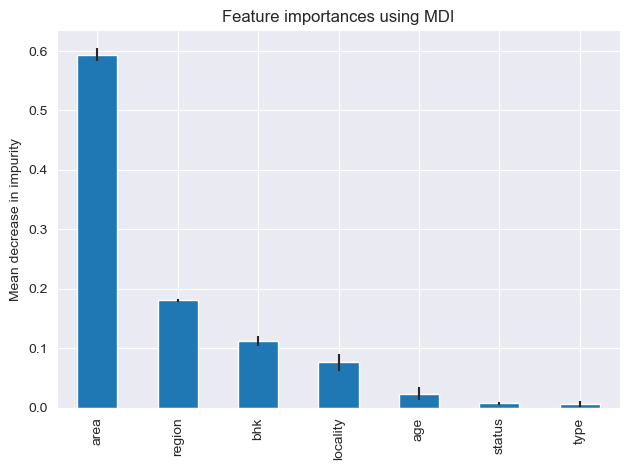

In [26]:
feature_names = [f"{column}" for column in X_train]
importances = loaded_model.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)
std = np.std([tree.feature_importances_ for tree in loaded_model.estimators_], axis=0)
sorted_importances = forest_importances.sort_values(ascending=False)
fig, ax = plt.subplots()
sorted_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [27]:
#Make the predictions 
Y_pred = loaded_model.predict(X_test)
pred_table = pd.DataFrame(data={"actual value":Y_test, "predicted":loaded_model.predict(X_test)})
pred_table["difference"] = pred_table["actual value"] - pred_table["predicted"]
pred_table

,actual value,predicted,difference
30699,99600.0,98878.058359,721.941641
36534,186000.0,204766.833879,-18766.833879
23586,39000.0,39796.740000,-796.740000
11125,116400.0,123154.945714,-6754.945714
54910,432000.0,472428.000000,-40428.000000
...,...,...,...
64796,252000.0,229198.566761,22801.433239
65343,390000.0,390000.000000,0.000000
4066,360000.0,325250.182129,34749.817871
25584,243600.0,259428.000000,-15828.000000


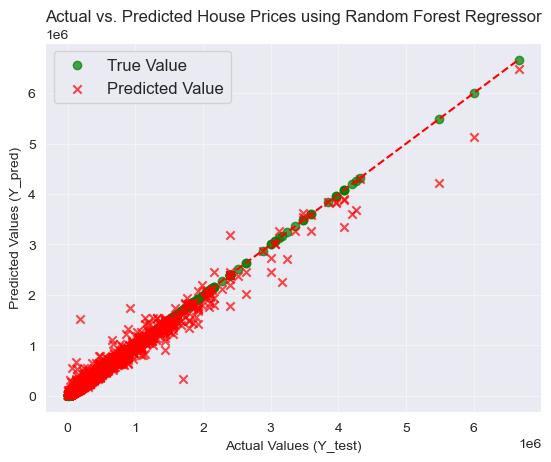

In [28]:
# Assuming you have obtained Y_pred and Y_test from your model

# Create a scatter plot or line plot
# Scatter plot for Y_test (green)
plt.scatter(Y_test, Y_test, c='green', marker='o', label='True Value', alpha=0.7)

# Scatter plot for Y_pred (red)
plt.scatter(Y_test, Y_pred, c='red', marker='x', label='Predicted Value', alpha=0.7)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--')  # Diagonal line for reference
plt.xlabel('Actual Values (Y_test)')
plt.ylabel('Predicted Values (Y_pred)')
plt.legend(fontsize=12)
plt.title('Actual vs. Predicted House Prices using Random Forest Regressor')
plt.grid(alpha=0.4)
# Show the plot
plt.show()

In [29]:
from sklearn.metrics import r2_score
#Test the model
pred_train = loaded_model.predict(X_train)
pred_val = loaded_model.predict(X_val)
pred_test = loaded_model.predict(X_test)
train_accuracy = r2_score(pred_train, Y_train)
val_accuracy = r2_score(pred_val, Y_val)
test_accuracy = r2_score(pred_test, Y_test)
print('Training accuracy: ',train_accuracy)
print('Validation accuracy: ', val_accuracy)
print('Test accuracy: ',test_accuracy)

Training accuracy:  0.9816796798819434
Validation accuracy:  0.9786242859655275
Test accuracy:  0.9788384860230276


In [30]:
from sklearn.metrics import mean_squared_error
mse_train = mean_squared_error(Y_train, pred_train)
mse_val = mean_squared_error(Y_val, pred_val)
mse_test = mean_squared_error(Y_test, pred_test)
print('Training mean squared error: ', mse_train)
print('Validation mean squared error: ', mse_val)
print('Test mean squared error: ', mse_test)

Training mean squared error:  1218630787.3887997
Validation mean squared error:  1278108473.6955678
Test mean squared error:  1303008854.9436853


In [31]:
from sklearn.metrics import mean_absolute_error
mae_train = mean_absolute_error(Y_train, pred_train)
mae_val = mean_absolute_error(Y_val, pred_val)
mae_test = mean_absolute_error(Y_test, pred_test)
print('Training mean absolute error: ', mae_train)
print('Validation mean absolute error: ', mae_val)
print('Test mean absolute error: ', mae_test)

Training mean absolute error:  10781.39840512653
Validation mean absolute error:  11048.369528392022
Test mean absolute error:  11031.003905049241
